In [1]:
import ROOT

Welcome to JupyROOT 6.26/00


In [1]:
# import packages
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import os
import sys
import hist

# set cms plot style
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from setting import setting

In [2]:
#config_path = "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL_alphavalidate_110to135.yml"
import yaml
config_path = "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL16.yml"
with open( config_path) as f:
    config = yaml.safe_load(f)

    
    
#####################
#make cut
def make_cut(selection,arr):
    r'''
    input: selection, arr as ak.Aarry()
    output: cuted arr with selection
    '''
    cut  = ak.numexpr.evaluate(selection,arr)
    return arr[cut]

In [4]:
year = '2018'

#samples = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf','TTTo2L2Nu','WWTo2L2Nu','WZTo2Q2L','ZZTo2Q2L','WWTo1L1Nu2Q','tZq','ZZTo2L2Nu','WZTo1L1Nu2Q','ggh1000','ggh500','sig','ggh2000']
#samples = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf','TTTo2L2Nu','WWTo2L2Nu','WZTo2Q2L','ZZTo2Q2L','tZq','ggh1000','sig']
samples = ['ggh500','ggh1000','ggh2500']
arr = {}
sumweight = {}
for sample in samples:
    arr[sample] = uproot.lazy([f"{setting().fileset[year][sample][0]}:passedEvents"])
    
    f = uproot.open(setting().fileset[year][sample][0])['sumWeights']
    sumweight[sample] = (f.to_boost()).sum()
    f.close()

In [5]:
#make cut 
arr_cut_merged = {}
selection_merged = config['cut']['merged']['net']['SR']['2lep']['all']
for sample in samples:
    arr_cut_merged[sample] = make_cut(selection_merged,arr[sample])

arr_cut_resolved = {}
selection_resolved = config['cut']['resolved']['SR']['2lep']['all']
for sample in samples:
    arr_cut_resolved[sample] = make_cut(selection_resolved,arr[sample])

In [5]:
arr_cut['ggh1000'].fields

['pConst_GG_SIG_ghg2_1_ghz1_1_JHUGen',
 'p_GG_SIG_ghg2_1_ghz1_1_JHUGen',
 'pConst_GG_SIG_kappaTopBot_1_ghz1_1_MCFM',
 'p_GG_SIG_kappaTopBot_1_ghz1_1_MCFM',
 'pConst_ZJJ_BKG_MCFM',
 'p_ZJJ_BKG_MCFM',
 'pAux_JVBF_SIG_ghv1_1_JHUGen',
 'p_JVBF_SIG_ghv1_1_JHUGen',
 'pConst_JJVBF_SIG_ghv1_1_JHUGen',
 'p_JJVBF_SIG_ghv1_1_JHUGen',
 'p_JJVBF_SIG_ghv1prime2_1E4_JHUGen',
 'p_JJVBF_SIG_ghv2_1_JHUGen',
 'p_JJVBF_SIG_ghv4_1_JHUGen',
 'p_JJVBF_SIG_ghza1prime2_1E4_JHUGen',
 'p_JJVBF_SIG_ghv1_1_ghv1prime2_1E4_JHUGen',
 'p_JJVBF_SIG_ghv1_1_ghv2_1_JHUGen',
 'p_JJVBF_SIG_ghv1_1_ghv4_1_JHUGen',
 'pConst_JQCD_SIG_ghg2_1_JHUGen',
 'p_JQCD_SIG_ghg2_1_JHUGen',
 'pConst_JJQCD_SIG_ghg2_1_JHUGen',
 'p_JJQCD_SIG_ghg2_1_JHUGen',
 'p_Gen_CPStoBWPropRewgt',
 'lep_1_pt',
 'lep_1_phi',
 'lep_2_pt',
 'lep_1_eta',
 'lep_2_eta',
 'lep_2_phi',
 'Nleptons',
 'Ntightleptons',
 'GENlep_DR',
 'n_addtional_looselep',
 'mass2jet',
 'mass2jet_mass_bais',
 'mass2jet_up',
 'mass2jet_dn',
 'pt2jet',
 'pt2jet_mass_bais',
 'pt2jet_up'

In [6]:
arr_cut['ggh1000'].pConst_GG_SIG_kappaTopBot_1_ghz1_1_MCFM

<Array [1.07e+07, 1.01e+07, ... 1.28e+07] type='51403 * float32'>

(array([20849.,  8325.,  6143.,  4990.,  4200.,  2899.,  1326.,  1017.,
          938.,   716.]),
 array([0.4137508 , 0.47228688, 0.530823  , 0.5893591 , 0.6478952 ,
        0.70643127, 0.7649674 , 0.8235035 , 0.88203955, 0.94057566,
        0.9991118 ], dtype=float32),
 <BarContainer object of 10 artists>)

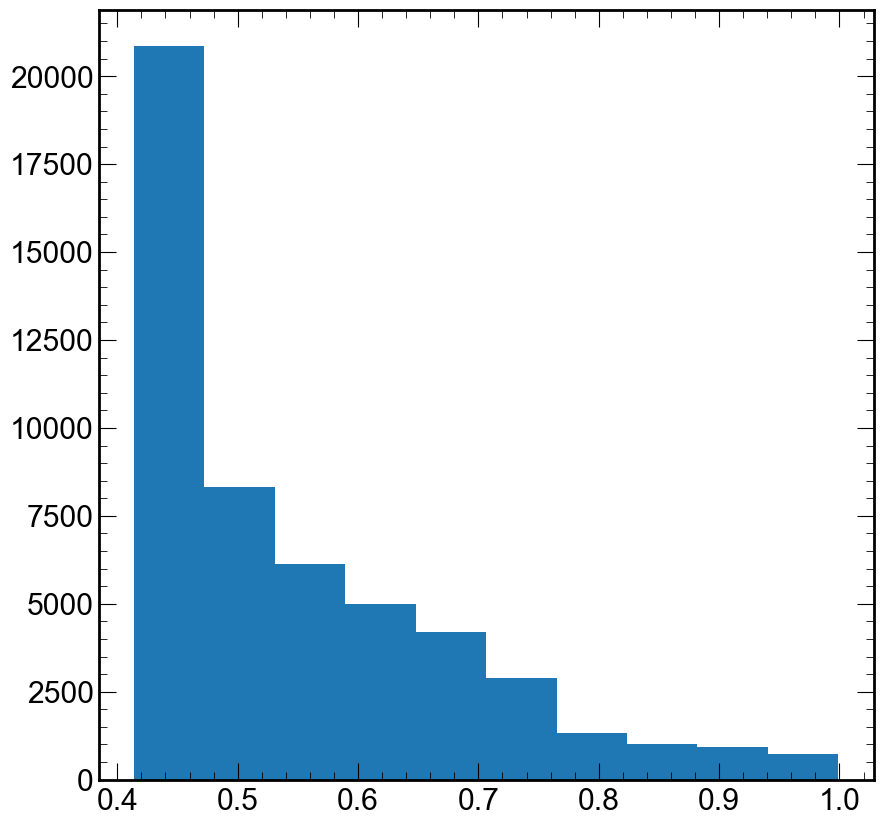

In [8]:
plt.hist(arr_cut['ggh1000'].p_Gen_CPStoBWPropRewgt)

In [6]:
#fill histo
#check varbs
varb = 'mass2lj' #
#fill hist
bins = 400; start = 0; stop = 4000
lumi = config['lumi']['2018']
h = {}
h_raw = {}
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h[sample] = hist.Hist(hist.axis.Regular(bins,start,stop))
    h[sample].fill(
        #arr_cut_resolved[sample]['mass2l2jet'] - arr_cut_resolved[sample]['GEN_H1_mass'],
        arr_cut_resolved[sample]['mass2l2jet'],
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*p_GG_SIG_kappaTopBot_1_ghz1_1_MCFM*p_Gen_CPStoBWPropRewgt/{sumweight[sample]}',arr_cut_resolved[sample])
        #weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000/{sumweight[sample]}',arr_cut_resolved[sample])
        #weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*p_Gen_CPStoBWPropRewgt/{sumweight[sample]}',arr_cut_resolved[sample])
    )

    h[sample].fill(
        #arr_cut_merged[sample]['mass2lj']-arr_cut_merged[sample]['GEN_H1_mass'],
        arr_cut_merged[sample]['mass2lj'],
        #weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000/{sumweight[sample]}',arr_cut_merged[sample])
        #weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*p_Gen_CPStoBWPropRewgt/{sumweight[sample]}',arr_cut_merged[sample])
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*p_GG_SIG_kappaTopBot_1_ghz1_1_MCFM*p_Gen_CPStoBWPropRewgt/{sumweight[sample]}',arr_cut_merged[sample])
    )

    # fill raw hist with remove p_GG_SIG_kappaTopBot_1_ghz1_1_MCFM*p_Gen_CPStoBWPropRewgt weight
    h_raw[sample] = hist.Hist(hist.axis.Regular(bins,start,stop))
    h_raw[sample].fill(
        arr_cut_merged[sample]['mass2lj'],
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000/{sumweight[sample]}',arr_cut_merged[sample])
    )

    h_raw[sample].fill(
        arr_cut_resolved[sample]['mass2l2jet'],
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000/{sumweight[sample]}',arr_cut_resolved[sample])
    )
    

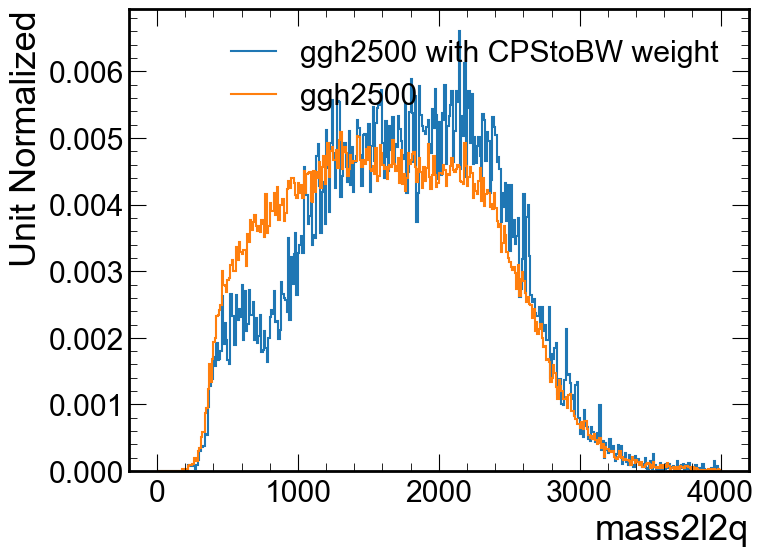

In [11]:
# draw comparison plot: h vs h_raw
plt.figure(figsize=(8,6))
sample = 'ggh2500'
h[f'{sample}'].plot1d(density = True,label = f'{sample} with CPStoBW weight')
h_raw[f'{sample}'].plot1d(density = True,label = f'{sample}')
#h['ggh500'].plot1d(density = True,label = 'ggh500 with CPStoBW weight')
##h_raw['ggh1000'].plot1d(density = True,label = 'ggh1000')
#set x and y axis title
plt.xlabel('mass2l2q')
plt.ylabel('Unit Normalized')
plt.legend()

In [7]:
plt.close()

In [8]:
#save hist in root file
with uproot.recreate(f'./histo_ggh500.root') as f:
    for sample in samples:
        f[f'{sample}'] = h[sample]

In [41]:
#tot eff
print(len(arr['ggh1000'].GEN_H1_mass))
print(len(arr_cut_resolved['ggh1000'].GEN_H1_mass))
print(len(arr_cut_merged['ggh1000'].GEN_H1_mass))
print('eff = {}'.format((len(arr_cut_resolved['ggh1000'].GEN_H1_mass) + len(arr_cut_merged['ggh1000'].GEN_H1_mass))/len(arr['ggh1000'].GEN_H1_mass)))

139912
9454
51403
eff = 0.43496626450912


# NEW Version Test

In [1]:
import ROOT

Welcome to JupyROOT 6.26/00


In [2]:
import matplotlib.pyplot as plt

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "/cms/user/guojl/miniconda/envs/uprootframe/bin/python"
  * The NumPy version is: "1.21.6"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: PyCapsule_Import could not import module "datetime"


OpenBLAS blas_thread_init: pthread_create failed for thread 11 of 28: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 200 current, 200 max
OpenBLAS blas_thread_init: pthread_create failed for thread 12 of 28: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 200 current, 200 max
OpenBLAS blas_thread_init: pthread_create failed for thread 13 of 28: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 200 current, 200 max
OpenBLAS blas_thread_init: pthread_create failed for thread 14 of 28: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 200 current, 200 max
OpenBLAS blas_thread_init: pthread_create failed for thread 15 of 28: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 200 current, 200 max
OpenBLAS blas_thread_init: pthread_create failed for thread 16 of 28: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 200 current, 200 max
OpenBLAS blas_th

In [ ]:
import numpy as np

In [ ]:
#define a Breit–Wigner function with required parameters: width, mass(center), current mass, branching ratio=1 in default
def BreitWigner(width, mass, current_mass, spline):
    branching_ratio = spline.Eval(current_mass)
    #return branching_ratio*((mass*width)/np.pi)*((2*current_mass)/((current_mass**2-mass**2)**2+(mass*width)**2))
    return branching_ratio*((2*current_mass)/((current_mass**2-mass**2)**2+(mass*width)**2))

In [ ]:
f_spline_ggh = ROOT.TFile("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/ggf_input_spline.root")
f_spline_vbf = ROOT.TFile("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/vbf_input_spline.root")

In [6]:
f_spline.ls()

NameError: name 'f_spline' is not defined

In [8]:
spline_ggh = f_spline_ggh.Get("sp_xsec_ggf_2e2mu")
spline_vbf = f_spline_vbf.Get("sp_xsec_vbf_2e2mu")

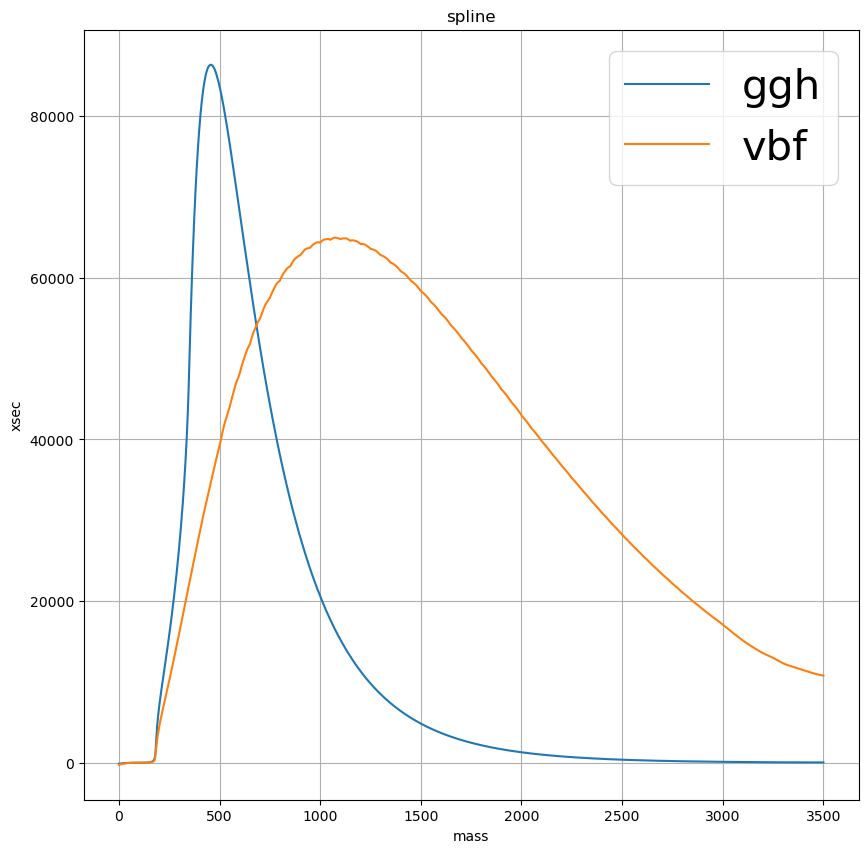

In [14]:
# plot spline ggh and vbf in the same plot
plt.figure(figsize=(10,10))
x = np.linspace(0,3500,3500)
y_ggh = np.array([spline_ggh.Eval(i) for i in x])
y_vbf = np.array([spline_vbf.Eval(i) for i in x])
#scale y_vbf to match with y_ggh
y_vbf = y_vbf*10000
plt.plot(x,y_ggh,label='ggh')
plt.plot(x,y_vbf,label='vbf')
plt.legend(loc='upper right', numpoints = 1, prop={'size': 30})
plt.xlabel('mass')
plt.ylabel('xsec')
plt.title('spline')
plt.grid(True)
plt.show()

In [11]:
# generate a function
start = 0; stop = 3500; step = 3500
x = np.linspace(start, stop, step)
y_0_500 = np.array([BreitWigner(0.001, 500, i, spline_ggh) for i in x])
y_10_500 = np.array([BreitWigner(10, 500, i, spline_ggh) for i in x])
y_0_1500 = np.array([BreitWigner(0.001, 1500, i, spline_ggh) for i in x])
y_10_1500 = np.array([BreitWigner(10, 1500, i, spline_ggh) for i in x])
y_0_3000 = np.array([BreitWigner(0.001, 3000, i, spline_ggh) for i in x])
y_10_3000 = np.array([BreitWigner(10, 3000, i, spline_ggh) for i in x])

/tmp/ipykernel_17221/3637154465.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1e5)


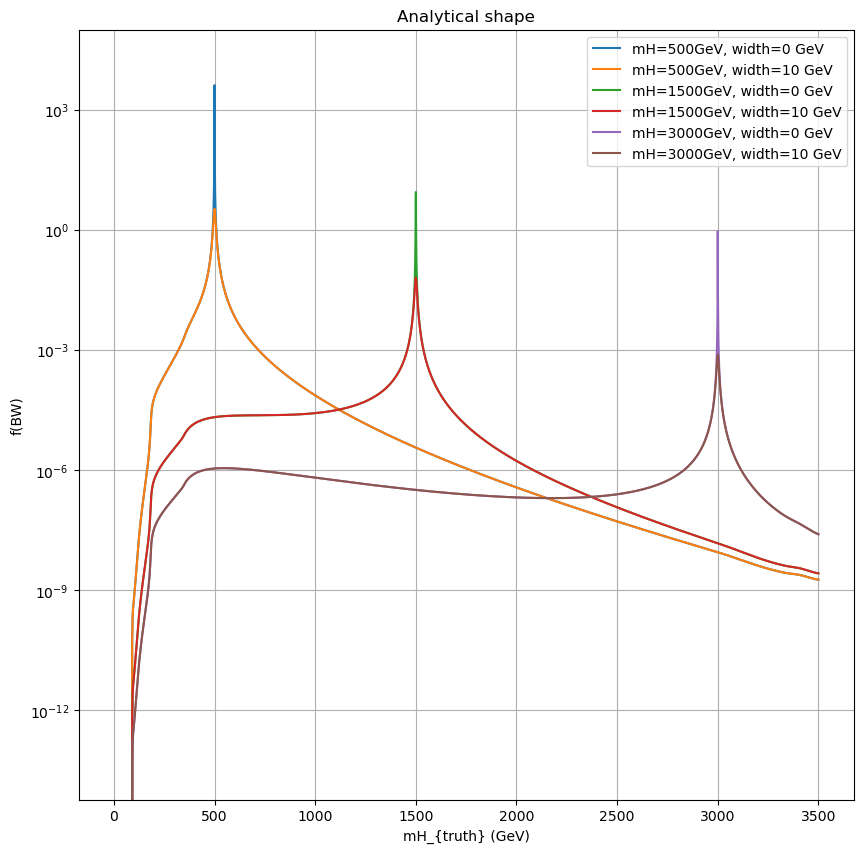

In [17]:
#create a plot
plt.figure(figsize=(10, 10))
#plt.plot(np.linspace(start, stop, step),y, label='mH=125GeV, width=1GeV')
plt.plot(np.linspace(start, stop, step),y_0_500, label='mH=500GeV, width=0 GeV')
plt.plot(np.linspace(start, stop, step),y_10_500, label='mH=500GeV, width=10 GeV')
plt.plot(np.linspace(start, stop, step),y_0_1500, label='mH=1500GeV, width=0 GeV')
plt.plot(np.linspace(start, stop, step),y_10_1500, label='mH=1500GeV, width=10 GeV')
plt.plot(np.linspace(start, stop, step),y_0_3000, label='mH=3000GeV, width=0 GeV')
plt.plot(np.linspace(start, stop, step),y_10_3000, label='mH=3000GeV, width=10 GeV')
plt.xlabel('mH_{truth} (GeV)')
plt.ylabel('f(BW)')
plt.title('Analytical shape')
plt.legend(loc='upper right', numpoints = 1, prop={'size': 10} )
#log scale
plt.yscale('log')
#set y range
plt.ylim(0, 1e5)
plt.grid(True)

In [15]:
plt.close()

In [29]:
ROOT.gInterpreter.ProcessLine('#include "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/SplinePdf.h"')

0

In file included from input_line_81:1:
/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/SplinePdf.h:21:7: error: redefinition of 'SplinePdf'
class SplinePdf : public RooAbsPdf {
      ^
input_line_76:1:10: note: '/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/SplinePdf.h' included multiple times, additional include site here
#include "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/SplinePdf.h"
         ^
input_line_81:1:10: note: '/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/SplinePdf.h' included multiple times, additional include site here
#include "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/SplinePdf.h"
         ^
/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/SignalModel/GeliangShare/public/h4l_highmass/SplinePdf.h:2

In [22]:
low_mass = 0; high_mass = 3500; current_mass = 500; width = 10

mass_range = ROOT.RooRealVar('mass_range','mass_range',low_mass,high_mass)
width = ROOT.RooRealVar('width','width',width,0,100)
mass_2l2q = ROOT.RooRealVar('mass_2l2q','mass_2l2q',current_mass,low_mass,high_mass)
mass_gen = ROOT.RooRealVar('mass_gen','mass_gen',current_mass,low_mass,high_mass)

In [30]:
higgspdf = ROOT.SplinePdf('higgspdf','higgspdf',mass_gen,mass_2l2q,width,spline_ggh)

TypeError: none of the 3 overloaded methods succeeded. Full details:
  SplinePdf constructor failed
  SplinePdf::SplinePdf(const SplinePdf& other, const char* name = 0) =>
    TypeError: takes at most 2 arguments (6 given)
  SplinePdf::SplinePdf() =>
    TypeError: takes at most 0 arguments (6 given)

IncrementalExecutor::executeFunction: symbol '_ZN9SplinePdfC1EPKcS1_R10RooAbsRealS3_S3_8TSpline3' unresolved while linking symbol '__cf_28'!
You are probably missing the definition of SplinePdf::SplinePdf(char const*, char const*, RooAbsReal&, RooAbsReal&, RooAbsReal&, TSpline3)
Maybe you need to load the corresponding shared library?
